In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse, fftpack
from math import factorial as fact
try:
    plt.style.use("jupyter")
except OSerror:
    print("Using default ploting style")
# L-p norm function
norm = lambda v, p=2 : (len(v)**(-p)*np.einsum('i->', np.abs(v)**2))**(1./p)

### Compact n$^{th}$-order derivative

The compact coefficients for the $n^{th}$ derivative $f^{(n)}$ of a function can be found by solving the system

$$
\begin{bmatrix}
    \begin{matrix}
        0 & 0 & 0
    \end{matrix} & \begin{matrix}
        1 & 1 & 1\\
    \end{matrix}\\
    Q^{(n)} & \begin{matrix}
h_{i-1} & 0 & h_{i+1}\\
h_{i-1}^2/2! & 0 & h_{i+1}^2/2!\\
h_{i-1}^3/3! & 0 & h_{i+1}^3/3!\\
h_{i-1}^4/4! & 0 & h_{i+1}^4/4!
\end{matrix}\\
\begin{matrix}
        0 & 1 & 0
    \end{matrix} & \begin{matrix}
        0 & 0 & 0\\
    \end{matrix}\\
\end{bmatrix}\begin{bmatrix}
L_{i-1} \\ L_{i} \\ L_{i+1} \\ -R_{i-1} \\ -R_{i} \\ -R_{i+1}\\
\end{bmatrix}=\begin{bmatrix}
0\\ 0\\ 0\\ 0\\ 0\\ 1\\,
\end{bmatrix}
$$

where $h_{i-1}=x_{i-1}-x_i$ and $h_{i+1} = x_{i+1}-x_i$. The sub-matrix $Q^{(n)}$ depends on the derivative required. For the first derivative, we have

$$
Q^{(1)} = \begin{bmatrix}
1 & 1 & 1\\
h_{i-1} & 0 & h_{i+1}\\
h_{i-1}^2/2! & 0 & h_{i+1}^2/2!\\
h_{i-1}^3/3! & 0 & h_{i+1}^3/3!\\
\end{bmatrix}
$$

and for the second derivative

$$
Q^{(2)} = \begin{bmatrix}
0 & 0 & 0\\
1 & 1 & 1\\
h_{i-1} & 0 & h_{i+1}\\
h_{i-1}^2/2! & 0 & h_{i+1}^2/2!\\
\end{bmatrix}.
$$

In [2]:
def get_compact_coeffs(n, hi):
    # assumes uniform grid
    h_i = -hi
    r = np.hstack((np.array([0 for i in range(5)]),1.))
    L = np.array([[0, 0, 0, 1, 1, 1],
                  [0, 0, 0, h_i, 0, hi],
                  [0, 0, 0, h_i**2/fact(2), 0, hi**2/fact(2)],
                  [0, 0, 0, h_i**3/fact(3), 0, hi**3/fact(3)],
                  [0, 0, 0, h_i**4/fact(4), 0, hi**4/fact(4)],
                  [0, 1, 0, 0, 0, 0]])
    insert = np.array([[1,           1,                1],
                       [h_i,         0,               hi],
                       [h_i**2/fact(2), 0, hi**2/fact(2)],
                       [h_i**3/fact(3), 0, hi**3/fact(3)]])
    L[n:5,:3] = insert[:-n+5,:]
    vec = np.round(np.linalg.solve(L, r), 8)
    return vec[:3], -vec[3:]

We can check that for a first derivative, we recover the standard Pade ($4^{th}$-order) [coefficients](https://github.com/marinlauber/my-numerical-recipes/blob/master/Compact-Schemes.ipynb), which are

$$
   L = \left[\frac{1}{4}, 1, \frac{1}{4}\right], \qquad R = \left[-\frac{3}{4}, 0., \frac{3}{4}\right]
$$

In [3]:
pade = np.array([1./4., 1., 1./4., -3./4., 0., 3./4.])
np.allclose(np.hstack(get_compact_coeffs(1, 1)), pade)

True

We can now write a function that, given a function $f$, on a uniform grid with spacing $dx$, return the $n^{th}$ derivative of that function. Because for each point we solve for the compact coefficients, we can in theory get compact schemes on non-uniform grid with the same accuracy. Here we will only focs on uniform grids.

In [4]:
def derive_compact(n, f, dx):
    
    # get coeffs
    L, R = get_compact_coeffs(n, dx)
    
    # temp array
    sol = np.empty_like(f)
    
    # compact scheme on interior points
    sol[2:-2] = R[0]*f[1:-3] + R[1]*f[2:-2] + R[2]*f[3:-1]
    
    # boundary points
    sol[-2] = R[0]*f[-3] + R[1]*f[-2] + R[2]*f[-1]
    sol[-1] = R[0]*f[-2] + R[1]*f[-1] + R[2]*f[-0]
    sol[ 0] = R[0]*f[-1] + R[1]*f[ 0] + R[2]*f[ 1]
    sol[ 1] = R[0]*f[ 0] + R[1]*f[ 1] + R[2]*f[ 2]
    
    # build ugly matrix by hand
    A = sparse.diags(L,[-1,0,1],shape=(len(f),len(f))).toarray()
    # periodic BS's
    A[ 0,-1] = L[0]
    A[-1, 0] = L[2]
        
    return np.linalg.solve(A, sol)

We can then test the method on a known function, with known first and second derivaive. For simplicity, we will use trigonometric functions, which have well-behaved infinite derivatives.

$$
    f(x) = \sin(x), \,\, x\in[0, 2\pi]
$$

such that

$$
    \frac{d}{dx}f(x) = \cos(x), \quad \frac{d^2}{dx^2}f(x) = -\sin(x), \,\, x\in[0, 2\pi]
$$

In [5]:
N = 128
x, dx = np.linspace(0, 2*np.pi, N, retstep=True, endpoint=False)
function = np.sin(x)

# first derivative
sol = derive_compact(1, function, dx)
print('First derivative L2 norm:  ', norm(sol-np.cos(x)))

# second derivative
sol = derive_compact(2, function, dx)
print('Second derivative L2 norm: ', norm(sol+np.sin(x)))

First derivative L2 norm:   2.00356231982653e-09
Second derivative L2 norm:  1.5119843767976088e-09


### Poisson Equation With Compact Schemes

We aim to solve the following one-dimensionnal Poisson equation with Dirichlet boudnary conditions

$$
\begin{split}
    -&\frac{d^2}{dx^2}u(x) = f(x), \quad a<x<b\\
    &u(a) = 0, \quad u(b) = 0\\
\end{split}
$$

where $a, b\in\mathbb{R}$, $u(x)$ is the unkown function and $f(x)$ is some given source function. We discretize the left side of the Poisson equaution ($u''_i$) using a compact finite difference scheme with fourth-order accuracy on a uniform grid with grid points being $x_i = a+ih, h=(b-a)/M, i=0, 1, 2,..., M$ where $M$ is a positive integer. 

$$
\frac{1}{10}u''_{i-1} + u''_i + \frac{1}{10}u''_{i+1} = \frac{6}{5}\frac{u_{i+1} + 2u_i + u_{i-1}}{h^2},
$$

or in a more common form,

$$
u''_{i-1} + 10u''_i + u''_{i+1} = \frac{12}{h^2}\left(u_{i+1} + 2u_i + u_{i-1}\right).
$$

This results in the following tri-diagonal system

$$
    AU''= \frac{12}{h^2}BU,
$$

where $U'' = (u''_1,u''_2,...,u''_M)^\top$ and $U = (u_1,u_2,...,u_M)^\top\in \mathbb{R}^{M-1}$. The tri-diagonal matrix $A, B \in \mathbb{R}^{M-1\times M-1}$ are

$$
A = \begin{bmatrix}
10 & 1 & 0 &\dots & 0 & 0 \\
1 & 10 & 1 &\dots & 0 & 0 \\
0 & 1 & 10 &\dots & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & \dots & 10 & 1 \\
0 & 0 & 0 &\dots & 1 & 10 \\
\end{bmatrix}, \qquad B = \begin{bmatrix}
-2 & 1 & 0 &\dots & 0 & 0 \\
1 & -2 & 1 &\dots & 0 & 0 \\
0 & 1 & -2 &\dots & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & \dots & -2 & 1 \\
0 & 0 & 0 &\dots & 1 & -2 \\
\end{bmatrix}.
$$

In addition, we have $-u''(x_i)=f(x_i), i=1,2,...,M-1$ i.e. $-U''=F$. We can re-write out system as

$$
   -\frac{12}{h^2}BU = AF,
$$

To obtaine the solution $U$, we simply need to solve the system.

In [6]:
def build_AB(M, h):
    A = sparse.diags([1.,10.,1.],[-1,0,1],shape=(M, M)).toarray()
    B = sparse.diags([1.,-2.,1.],[-1,0,1],shape=(M, M)).toarray()
    # dont forget BC, here homogeneous Dirichlet
    B[ 0,:]=0.; B[ 0, 0]=1
    B[-1,:]=0.; B[-1,-1]=1
    return A, -12./h**2*B

In the first example, we consider the problem with homogeneous Dirichlet boundary conditions

$$
\begin{cases}
    -u''(x) = \pi^2\sin(\pi x), & 0 < x <2,\\
      u(0)=0, \quad u(2) = 0.
\end{cases}
$$

The exact solution is $u_e(x)=\sin(\pi x)$.

In [7]:
def SolvePoissonCompact(f, h, M):
    u0 = np.zeros_like(f)
    A, B = build_AB(M, h)
    sigma = np.matmul(A, f)
    return np.linalg.solve(B, sigma)

6.02248257496857e-06


Text(0, 0.5, '$u$')

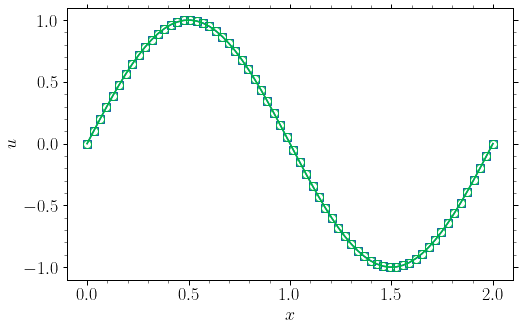

In [8]:
M = 64
x, h = np.linspace(0., 2., M, retstep=True, endpoint=True)
f = np.pi**2*np.sin(np.pi*x)
u_e = np.sin(np.pi*x)
u_num =  SolvePoissonCompact(f, h, M)
print(norm(u_num-u_e))
plt.plot(x, u_e, '-s')
plt.plot(x, u_num,'-o')
plt.xlabel(r"$x$");plt.ylabel(r"$u$")
# plt.savefig("figure_1.png", dpi=300);

Now with non-zero Dirichlet Boundry conditions

$$
\begin{cases}
    -u''(x) = 12e^{-x^2}(-x^2+1/2), & -8 < x <8,\\
      u(-8)=-8, \quad u(8) = 8.
\end{cases}
$$

The exact solution is $u_e(x)=3e^{-x^2}$. I. the numerical computation, we denote $U(x)=u(x)-x$ using change of variable. Applying tthe numerical algorithm, we now have 

$$
\begin{cases}
    -U''(x) = 12e^{-x^2}(-x^2+1/2), & -8 < x <8,\\
      U(-8)=-0, \quad U(8) = 0.
\end{cases}
$$

and the approximate numerical solution at a grid point is found as $u(x) = U(x)=x$. 

0.5864429590964948


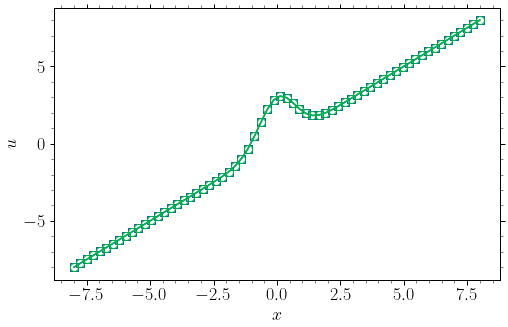

In [9]:
M = 64
x, h = np.linspace(-8., 8., M, retstep=True, endpoint=True)
f = 12.*np.exp(-x**2)*(-x**2 + 0.5)
u_e = 3.*np.exp(-x**2)+x
u_num = SolvePoissonCompact(f, h, M)
print(norm(u_num-u_e))
plt.plot(x, u_e, '-s')
plt.plot(x, u_num+x,'-o')
plt.xlabel(r"$x$");plt.ylabel(r"$u$");
# plt.savefig("figure_2.png", dpi=300);

### Using Faste Fourier Transforms to Solve the Poisson Equation


We actually do not need ton inverte the system described earlier to get the solution, [see](https://www.sciencedirect.com/science/article/pii/S0898122116300761). We can use the Sine transform for $U\in\mathbb{R}^{M-1}$

$$
\begin{split}
    u_j &= \sum_{k=1}^{M-1}\hat{u}_k\sin\left(\frac{jk\pi}{M}\right), \,\, j=1,2,...,M-1,\\
    \hat{u_k} &= \frac{2}{M}\sum_{j=1}^{M-1}u_j\sin\left(\frac{ik\pi}{M}\right), \,\, j=1,2,...,M-1,
\end{split}
$$

from whcih we can approximate $u_{i+1}, u_{i-1}, u''_{i+1}, u''_{i-1}$ as

$$
\begin{align}
   u_{i+1}=\sum_{k=1}^{M-1}\hat{u}_k\sin\left(\frac{(i+1)k\pi}{M}\right),\qquad & u_{i-1} = \sum_{k=1}^{M-1}\hat{u}_k\sin\left(\frac{(i-1)k\pi}{M}\right)\\
   u''_{i} =\sum_{k=1}^{M-1}\hat{u}''_k\sin\left(\frac{ik\pi}{M}\right),\qquad & u''_{i+1} =\sum_{k=1}^{M-1}\hat{u}''_k\sin\left(\frac{(i+1)k\pi}{M}\right)\\
   u''_{i-1} =\sum_{k=1}^{M-1}\hat{u}''_k\sin\left(\frac{(i-1)k\pi}{M}\right). & \\
\end{align}
$$

Subsituting in the compact discretization of the Poisson equation gives, 

$$
\sum_{k=1}^{M-1}\hat{u}''_k\left\{ \frac{1}{10}\sin\left(\frac{(i-1)k\pi}{M}\right) + \sin\left(\frac{ik\pi}{M}\right) + \frac{1}{10}\sin\left(\frac{(i+1)k\pi}{M}\right) \right\} =\frac{6}{5h^2}\sum_{k=1}^{M-1}\hat{u}_k\left\{ \sin\left(\frac{(i-1)k\pi}{M}\right) +\sin\left(\frac{(i+1)k\pi}{M}\right) - 2\sin\left(\frac{ik\pi}{M}\right) \right\}
$$

or, after rearranging

$$
\hat{u}_k = -\hat{u}''_k\left(\frac{24\sin^2\left(\frac{k\pi}{2M}\right)}{h^2}\right)^{-1}\left(\cos\left(\frac{k\pi}{M}\right)+5\right), \,\, k\in 1,2,..,M-1.
$$

In addition, we obtain $-u''_i = f_i \,(i=1,2,...,M-1)$. By the inverse Sine transform, we get to know $-\hat{u}''_k=\hat{f}_k \, (k=1,2,...,M-1)$, whci allows us to solve for $\hat{u}$

$$
\hat{u}_k = \hat{f}_k\left(\frac{24\sin^2\left(\frac{k\pi}{2M}\right)}{h^2}\right)^{-1}\left(\cos\left(\frac{k\pi}{M}\right)+5\right), \,\, k\in 1,2,..,M-1.
$$

> **_Note:_** We use a spectral method to solve the tri-diagonal system, this doesn't mean we solve it with spectral accuracy, here the modified wavenumber makes the spectral method the exact same accuracy as the compact scheme.


In [10]:
def SolvePoissonSine(f, h, M):
    f_k = fftpack.dst(f, norm='ortho')
    k = np.arange(1,M+1)
    u_k = f_k*(24*np.sin(k*np.pi/(2*M))**2./h**2.)**(-1.)*(np.cos(np.pi*k/M)+5.)
    return fftpack.idst(u_k, norm='ortho')

0.5864429590964948


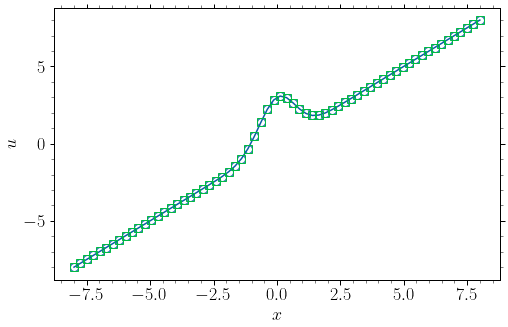

In [11]:
M = 64
x, h = np.linspace(-8, 8, M, retstep=True, endpoint=True)
f = 12.*np.exp(-x**2)*(-x**2 + 0.5)
u_e = 3.*np.exp(-x**2)+x
u_num = SolvePoissonSine(f, h, M)
print(norm(u_num-u_e))
plt.plot(x, u_num + x, '-o')
plt.plot(x, u_e, 's')
plt.xlabel(r"$x$");plt.ylabel(r"$u$");
# plt.savefig("figure_3.png", dpi=300);

### Order of Accuracy



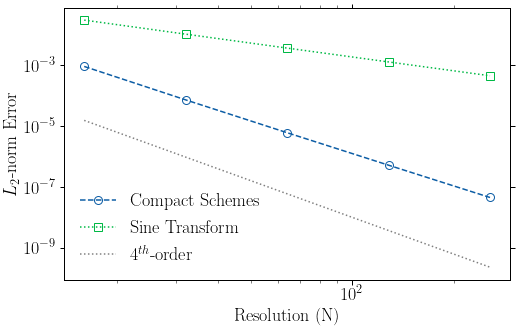

In [12]:
L2_com = []
L2_Sine = []
Resolutions = 2.**np.arange(4,9)
for N in Resolutions:
    x, h = np.linspace(0., 2., int(N), retstep=True, endpoint=True)
    f = np.pi**2*np.sin(np.pi*x)
    u_e = np.sin(np.pi*x)
    u_num = SolvePoissonCompact(f, h, int(N))
    error = norm(u_num-u_e)
    L2_com.append(error)
    u_num = SolvePoissonSine(f, h, int(N))
    error = norm(u_num-u_e)
    L2_Sine.append(error)
plt.loglog(Resolutions, np.array(L2_com), '--o', label='Compact Schemes')
plt.loglog(Resolutions, np.array(L2_Sine), ':s', label='Sine Transform')
plt.loglog(Resolutions, Resolutions**(-4), ':k', alpha=0.5, label=r"$4^{th}$-order")
plt.xlabel("Resolution (N)"); plt.ylabel(r"$L_2$-norm Error")
plt.legend();
# plt.savefig("figure_4.png", dpi=300);